<a href="https://colab.research.google.com/github/wkba/kaggle/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install kaggle
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# Google Colaboratory上からGoogle Drive上のファイルにアクセスできるようにする
from google.colab import drive
drive.mount('/content/drive')

# ~/.kaggleディレクトリを作成し、ここへDrive上のkaggle.jsonをコピーしてくる
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

#データダウンロード
!kaggle competitions download -c titanic -p /content/drive/MyDrive/kaggle/tmp_data/titanic

#処理
# import pandas as pd

#サブミット
#!kaggle competitions submit -c titanic -f "/content/drive/MyDrive/tmp_data/santander-product-recommendation/gender_submission.csv" -m "Message"

Not connected to a GPU
Mounted at /content/drive
train.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import pandas as pd
import numpy as np

In [5]:
train_df = pd.read_csv("/content/drive/MyDrive/kaggle/tmp_data/titanic/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/kaggle/tmp_data/titanic/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/kaggle/tmp_data/titanic/gender_submission.csv")

ランダムシードを設定する

In [6]:
import random
np.random.seed(1234)
random.seed(1234)

In [7]:
print(train_df.shape)
print(test_df.shape)

(891, 12)
(418, 11)


質的変数、量的変数を意識

In [8]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


カテゴリ変数を確認する

In [9]:
train_df["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [10]:
train_df["Cabin"].value_counts()

C23 C25 C27    4
G6             4
B96 B98        4
D              3
C22 C26        3
              ..
D9             1
F E69          1
E38            1
B79            1
B50            1
Name: Cabin, Length: 147, dtype: int64

欠損を確認する


In [11]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

データを可視化する

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
plt.style.use("ggplot")


目的変数について可視化する

In [15]:
train_df[["Embarked","Survived","PassengerId"]]

,Embarked,Survived,PassengerId
0,S,0,1
1,C,1,2
2,S,1,3
3,S,1,4
4,S,0,5
...,...,...,...
886,S,0,887
887,S,1,888
888,S,0,889
889,C,1,890


In [16]:
# 欠損値を含む行を削除する
train_df[["Embarked","Survived","PassengerId"]].dropna()

,Embarked,Survived,PassengerId
0,S,0,1
1,C,1,2
2,S,1,3
3,S,1,4
4,S,0,5
...,...,...,...
886,S,0,887
887,S,1,888
888,S,0,889
889,C,1,890


In [17]:
train_df[["Embarked","Survived","PassengerId"]].dropna().groupby(["Embarked", "Survived"]).count()

PassengerId
Embarked Survived             
C        0                  75
         1                  93
Q        0                  47
         1                  30
S        0                 427
         1                 217

In [18]:
# 横持ちに変換する
embarked_df = train_df[["Embarked","Survived","PassengerId"]].dropna().groupby(["Embarked", "Survived"]).count().unstack()
embarked_df

PassengerId     
Survived           0    1
Embarked                 
C                 75   93
Q                 47   30
S                427  217

積み上げ棒グラフで可視化する

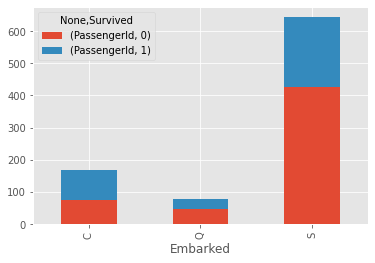

In [19]:
embarked_df.plot.bar(stacked=True)

数値で確認する

In [20]:
embarked_df["survived_rate"] = embarked_df.iloc[:, 0] / (embarked_df.iloc[:, 0] + embarked_df.iloc[:, 1])

In [21]:
embarked_df

PassengerId      survived_rate
Survived           0    1              
Embarked                               
C                 75   93      0.446429
Q                 47   30      0.610390
S                427  217      0.663043

性別やチケット、階級で可視化する

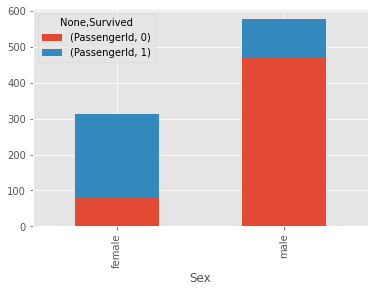

In [22]:
sex_df = train_df[["Sex", "Survived", "PassengerId"]].dropna().groupby(["Sex", "Survived"]).count().unstack()
sex_df.plot.bar(stacked=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


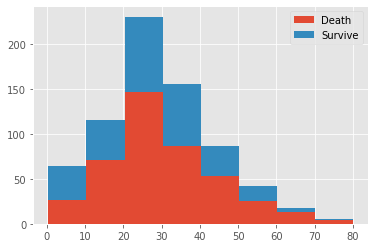

In [23]:
plt.hist(
    (train_df[train_df["Survived"]== 0][["Age"]].values, train_df[train_df["Survived"]==1][["Age"]].values),
    histtype="barstacked", #積み上げヒストグラム
    bins=8, #ビンの数
    label=("Death", "Survive") #ラベル名
    )
plt.legend()

カテゴリ変数をダミー変数化する

In [24]:
train_df_corr = pd.get_dummies(train_df, columns=["Sex"], drop_first=True)
train_df_corr = pd.get_dummies(train_df_corr, columns=["Embarked"])

In [25]:
train_df_corr

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,NaN,1,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,0,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",NaN,1,2,W./C. 6607,23.4500,NaN,0,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,C148,1,1,0,0


相関行列を作成する
変数同士の相関を見る

In [27]:
train_corr = train_df_corr.corr()

In [28]:
train_corr

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,0.042939,-0.001205,-0.033606,0.022148
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,-0.543351,0.168240,0.003650,-0.155660
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.131900,-0.243292,0.221009,0.081720
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.093254,0.036261,-0.022405,-0.032523
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.114631,-0.059528,-0.026354,0.070941
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,-0.245489,-0.011069,-0.081228,0.063036
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,-0.182333,0.269335,-0.117216,-0.166603
Sex_male,0.042939,-0.543351,0.131900,0.093254,-0.114631,-0.245489,-0.182333,1.000000,-0.082853,-0.074115,0.125722
Embarked_C,-0.001205,0.168240,-0.243292,0.036261,-0.059528,-0.011069,0.269335,-0.082853,1.000000,-0.148258,-0.778359
Embarked_Q,-0.033606,0.003650,0.221009,-0.022405,-0.026354,-0.081228,-0.117216,-0.074115,-0.148258,1.000000,-0.496624


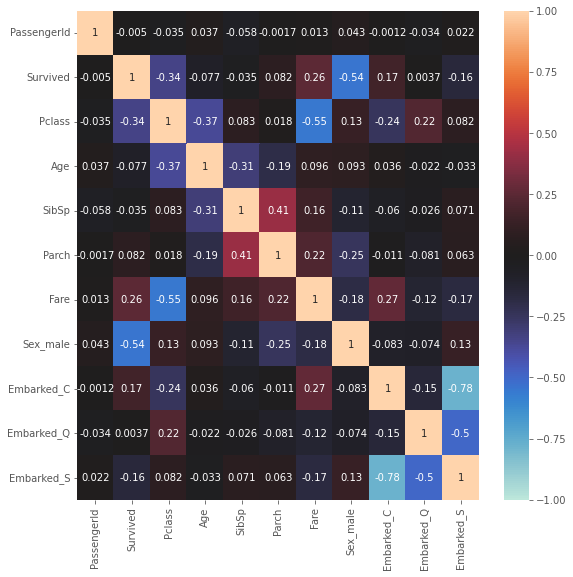

In [29]:
# ヒートマップで可視化する
plt.figure(figsize=(9,9))
sns.heatmap(train_corr, vmax=1, vmin=-1, center=0, annot=True)

In [31]:
# 前処理

all_df = pd.concat(
    [train_df, test_df], sort=False #結合後の行の並びが変わらないようにする
    ).reset_index(drop=True) #結合した後のデータで上の番号を振りなおします。元の行番号を削除
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [32]:
 # 全体データの欠損値の数を確認する
 all_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

欠損データを穴埋めする

In [34]:
Fare_mean = all_df[["Pclass","Fare"]].groupby("Pclass").mean().reset_index()

In [38]:
all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()

,Pclass,Fare
0,1,87.508992
1,2,21.179196
2,3,13.302889


カラム名　変更


In [45]:
Fare_mean.columns=["Pclass", "Fare_mean"]

In [46]:
Fare_mean

,Pclass,Fare_mean
0,1,87.508992
1,2,21.179196
2,3,13.302889


欠損値を置き換える

In [47]:
all_df= pd.merge(all_df, Fare_mean, on="Pclass", how="left") #Pclassでall_dfを紐付ける
all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"] # 欠損しているものをFare_meanで置き換える
all_df = all_df.drop("Fare_mean", axis=1) # 一括でfillnaするよりも、細かな制御ができる

敬称に注目する

In [48]:
all_df["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

敬称を変数として追加する

In [50]:
name_df = all_df["Name"].str.split("[,.]", 2, expand=True) # strで文字列を取得して、カンマとピリオドで区切る。

In [53]:
name_df.columns = ["family_name", "honorific", "name"]
name_df

,family_name,honorific,name
0,Braund,Mr,Owen Harris
1,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
2,Heikkinen,Miss,Laina
3,Futrelle,Mrs,Jacques Heath (Lily May Peel)
4,Allen,Mr,William Henry
...,...,...,...
1304,Spector,Mr,Woolf
1305,Oliva y Ocana,Dona,Fermina
1306,Saether,Mr,Simon Sivertsen
1307,Ware,Mr,Frederick


In [56]:
#空白削除
name_df["family_name"] = name_df["family_name"].str.strip()
name_df["honorific"] = name_df["honorific"].str.strip()
name_df["name"] = name_df["name"].str.strip()

継承毎に人数をカウント

In [57]:
name_df["honorific"].value_counts

<bound method IndexOpsMixin.value_counts of 0           Mr
1          Mrs
2         Miss
3          Mrs
4           Mr
         ...  
1304        Mr
1305      Dona
1306        Mr
1307        Mr
1308    Master
Name: honorific, Length: 1309, dtype: object>

敬称ごとの年齢分布を確認する

In [58]:
all_df = pd.concat([all_df, name_df], axis=1)
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_mean_x,Fare_mean_y,family_name,honorific,name
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,13.302889,13.302889,Braund,Mr,Owen Harris
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,87.508992,87.508992,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,13.302889,13.302889,Heikkinen,Miss,Laina
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,87.508992,87.508992,Futrelle,Mrs,Jacques Heath (Lily May Peel)
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,13.302889,13.302889,Allen,Mr,William Henry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,13.302889,13.302889,Spector,Mr,Woolf
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,87.508992,87.508992,Oliva y Ocana,Dona,Fermina
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,13.302889,13.302889,Saether,Mr,Simon Sivertsen
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,13.302889,13.302889,Ware,Mr,Frederick


箱ひげ図を用いる

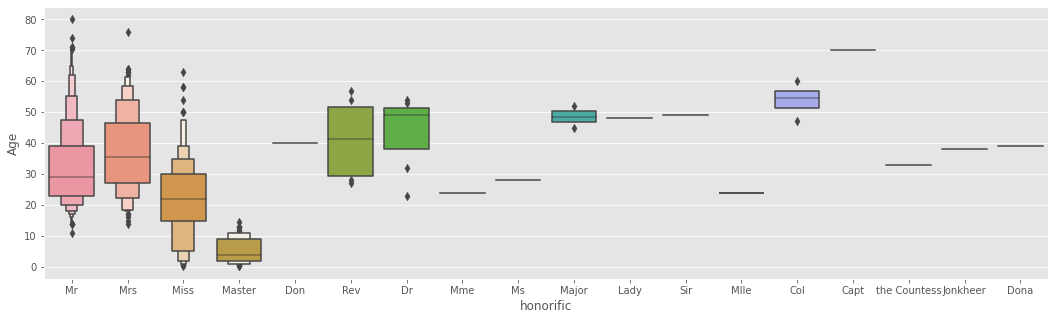

In [59]:
plt.figure(figsize=(18,5))
sns.boxenplot(x="honorific", y="Age", data=all_df)

In [61]:
all_df[["Age", "honorific"]].groupby("honorific").mean()

,Age
honorific,
Capt,70.000000
Col,54.000000
Don,40.000000
Dona,39.000000
Dr,43.571429
Jonkheer,38.000000
Lady,48.000000
Major,48.500000
Master,5.482642


敬称ごとの生存率の違いについて理解する

In [62]:
train_df = pd.concat([train_df, name_df[0:len(train_df)].reset_index(drop=True)], axis=1)
test_df = pd.concat([train_df, name_df[len(train_df):].reset_index(drop=True)], axis=1)


特定の項目を抜き出して、欠損値を含む行を削除し、honorifc/Survivedごとに人数を修正する

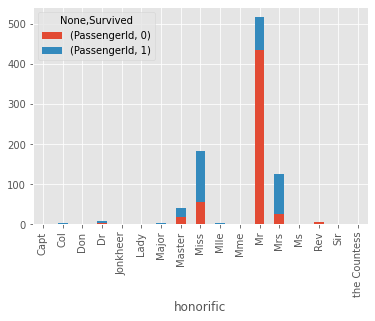

In [69]:
honorific_df = train_df[["honorific","Survived", "PassengerId"]].dropna().groupby(["honorific", "Survived"]).count().unstack()
honorific_df.plot.bar(stacked=True)

In [67]:
train_df[["honorific","Survived", "PassengerId"]].dropna().groupby(["honorific", "Survived"]).count()

PassengerId
honorific    Survived             
Capt         0                   1
Col          0                   1
             1                   1
Don          0                   1
Dr           0                   4
             1                   3
Jonkheer     0                   1
Lady         1                   1
Major        0                   1
             1                   1
Master       0                  17
             1                  23
Miss         0                  55
             1                 127
Mlle         1                   2
Mme          1                   1
Mr           0                 436
             1                  81
Mrs          0                  26
             1                  99
Ms           1                   1
Rev          0                   6
Sir          1                   1
the Countess 1                   1

In [70]:
# 年齢が欠損しているものは、敬称ごとの平均年齢で補完する
honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").mean().reset_index()

In [73]:
honorific_age_mean.columns = ["honorific", "honorific_Age"]
all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_Age"]
all_df = all_df.drop(["honorific_Age"], axis=1)

家族の人数を追加する

In [75]:
all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

In [77]:
all_df["family_num"].value_counts()

0     790
1     235
2     159
3      43
5      25
4      22
6      16
10     11
7       8
Name: family_num, dtype: int64

一人かどうかを表す変数を追加

In [78]:
all_df.loc[all_df["family_num"]==0, "alone"]=1
all_df["alone"].fillna(0, inplace=True)

不要な変数を削除する

In [79]:
all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)


カテゴリ変数を数字に変換する

In [82]:
categories = all_df.columns[all_df.dtypes=="object"]
print(categories)

Index(['Sex', 'Embarked', 'honorific'], dtype='object')


In [83]:
all_df.loc[~((all_df["honorific"]=="Mr") | 
             (all_df["honorific"]=="Miss") |
             (all_df["honorific"] == "Mrs") |
             (all_df["honorific"] == "Master")),"honorific"]= "other"

In [84]:
all_df.honorific.value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
other      34
Name: honorific, dtype: int64

ラベルエンコーディング

In [87]:
all_df["Embarked"].fillna("missing", inplace=True)

In [89]:
from sklearn.preprocessing import LabelEncoder
for cat in categories:
  le = LabelEncoder()
  print(cat)
  if all_df[cat].dtypes == "object":
    print(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])

Sex
Embarked
honorific


データを戻す

In [ ]:
train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop~True)

